# FV of Non Newtonian fluids using FiPy package - Part 3

In this notebook I will describe how to implement a 2D simple solution for non newtonian fluids using numercial solution. It will be used the Finite volume discretization implmented in the FiPy package.

It will go from simple reproduction of exemples inside the FiPy package until the adaptation of the equations to the non-newtonian fluid case.

First example was the solution of a 1D constant mesh of difusion problem, in the second part 2 I reproduced the stokes flow of a newtonian fluid.

The goverging equation of the diffusion equation was

$$\begin{equation}\label{eq:Diff}
\frac{\partial \phi}{\partial t}=D \nabla^2 \phi  \end{equation}$$

For stokes cavity equation we used the following governing equations:

$$\begin{equation}\label{eq:StokesCav}
\nabla\cdot(\mu\nabla\mathbf{u})=\nabla p
\end{equation}$$

And the continuity equation for incompressible fluid
$$\begin{equation}\label{eq:Conteq}
\nabla\cdot\mathbf{u}=0
\end{equation}$$
Where $\mathbf{u}$ is the fluid velocity field, $\mu$ is the dynamic viscosity and $p$ is the pressure field.

In this Third part we use the study of the stokes cavity exemple from FiPy, where it is used a Newtonian fluid in the problem. We will adapt the solution used to incorporate a instant non Newtonian fluid. Thus, the governing equation associated with momentum difusion will have to be re-written as folows:

$$\begin{equation}\label{eq:StokesCav-PL}
\nabla\cdot\tau=\nabla p
\end{equation}$$
Where $\tau$ is
$$\begin{equation}\label{eq:Stress-Tensor}
\tau=\mu(\dot\gamma)\dot\gamma
\end{equation}$$
And the apparent viscosity $\mu(\dot\gamma)$ is defined in the case of Ostwald fluids as:
$$\begin{equation}\label{eq:Stress-PL}
\mu(\dot\gamma)=C|\dot\gamma|^{m-1}
\end{equation}$$
Thus resulting in the final model below
$$\begin{equation}\label{eq:StokesCav-PL-1}
\nabla\cdot(C\dot|\dot\gamma|^{m-1}\dot\gamma)=\nabla p
\end{equation}$$

Where $C$ and $m$ are two material constants. $C$ tipically related to the difusion of moomentum and $m$ is associated to the fluid behavior. At this form we assume a generalized newtonian fluid model. For a 2-D flow, $\dot\gamma$ can be written as:
$$\begin{equation}\label{eq:gamma-2D}
\dot\gamma=\left[ \begin{array}{c c}
2\frac{\partial u}{\partial x} & \left(\frac{\partial u}{\partial y}+\frac{\partial v}{\partial x} \right)\\
\left(\frac{\partial u}{\partial y}+\frac{\partial v}{\partial x} \right) & 2\frac{\partial v}{\partial y}
\end{array}\right]
\end{equation}$$
Or in a compact form
$$
\dot\gamma=\frac{1}{2}(\nabla u+\nabla u^T)
$$
We can then re-write $\ref{eq:StokesCav-PL-1}$ as
$$
\begin{equation}\label{eq:StokesCav-PL-2}
\nabla\cdot\left(\frac{C}{2}\dot|\dot\gamma|^{m-1}\nabla u\right)+\nabla\cdot\left(\frac{C}{2}\dot|\dot\gamma|^{m-1}\nabla u^T\right)=\nabla p
\end{equation}
$$
We shaw work on Eq. $\ref{eq:StokesCav-PL-2}$ in order to obtain a better visualizarion of the equations to take place in the augorithm. In this case we re-write it using index notation. Resultin in

$$
\begin{equation}\label{eq:StokesCav-PL-3}
\frac{\partial }{\partial x_i}\left(\frac{C}{2}|\dot\gamma|^{m-1}\frac{\partial u_k}{\partial x_i}\right)\mathbf{e}_k+
\frac{\partial }{\partial x_i}\left(\frac{C}{2}|\dot\gamma|^{m-1}\frac{\partial u_i}{\partial x_k}\right)\mathbf{e}_k=
\frac{\partial p}{\partial x_k}\mathbf{e}_k
\end{equation}
$$
Note that in this case we have 2 equations, for the 2 directions and 2 velocity variables which are in both equation. Therefore we will use a solution where we first solve one equation for one vleocity direction and we use the result to solve for he other direction.

We start importing the required libraries and setting some governing parameters of the problem. It is very lickely the part 2 of this development, but here we have also to include $C$ and $m$ values. 

Here we consider a 2D cavity with unit dimensions, no-slip condition at the walls, with a unit speed at the upper boundary. The mesh will consist of 50x50 grid.

In [29]:
from fipy import *
from fipy.tools import numerix
L = 1.0 #CAnvity dimensions
N = 50 #Number of divisions
dL = L / N #Cel sizes
viscosity = 1. #Consistency viscosity value
m=1.5 #Fisrt value of the behavior constant will set the case as newtonian
eps=0.01 #criteria to stop
U = 1.0 #upper boundary fluid velocity
#0.8 for pressure and 0.5 for velocity are typical relaxation values for SIMPLE
#worked for m=0.25
#pressureRelaxation = 0.1
#velocityRelaxation = 0.04 
pressureRelaxation = 0.4
velocityRelaxation = 0.02 
Re=U**(2-m)*L**m/viscosity
#the number of sweeps when explicit called is 300, when runing as instance of a test is 5
if __name__ == '__main__':
    sweeps = 3000
else:
    sweeps = 5

We then build the mesh using a 2D grid.

In [2]:
mesh = Grid2D(nx=N, ny=N, dx=dL, dy=dL)

Then, we create the variables which keeps the solution value and initialize it with null values. In this case we need variables for pressure, pressure correction, and two direcions of the velocity field.

In [3]:
pressure = CellVariable(mesh=mesh, name='pressure')
pressureCorrection = CellVariable(mesh=mesh)
xVelocity = CellVariable(mesh=mesh, name='X velocity')
yVelocity = CellVariable(mesh=mesh, name='Y velocity')

In [4]:
velocity_variable=CellVariable(mesh=mesh, name='vel_var',rank=1)

We add a new shear strain variable since we need that to calculate the Apparent viscosity.

In [5]:
velocity = FaceVariable(mesh=mesh, rank=1)

In [6]:
shear_strain=CellVariable(mesh=mesh,value=velocity_variable.grad,name='ShearStrain',rank=2)

In [7]:
shear_strain.setValue(velocity_variable.grad)

For Coupling purpose the velocity is also declared in as a face variable. It will be used as a maner to use SIMPLE calculation for pressure correction

We have to set the function to calculate the shear strain at the mesh values

Now we have to set the equations to be solved. Since the cofficient depends on the absolute value of the speed gradient we have to build a function that delivers the shear strain tebsor.

In [8]:
du,dv=shear_strain[0]
dw,dy=shear_strain[1]

In [9]:
grad_transpose=CellVariable(mesh=mesh,value=[[du,dw],[dv,dy]], name='Grad Trasnpose',rank=2)

In [10]:
shear_strain=CellVariable(mesh=mesh,value=1./2.*(velocity_variable.grad+grad_transpose),name='ShearStrain',rank=2)

In [11]:
shear_cellvalue=CellVariable(mesh=mesh,value=1.)

Wecollect the array value from the shear variable

In [12]:
SS=shear_cellvalue.value

We create the terms for anisotropic diferential equation

In [13]:
xTerm1=CellVariable(mesh=mesh,value=[[0.,0.],[0.,0.]])
xTerm2=CellVariable(mesh=mesh,value=[[0.,0.],[0.,0.]])
yTerm1=CellVariable(mesh=mesh,value=[[0.,0.],[0.,0.]])
yTerm2=CellVariable(mesh=mesh,value=[[0.,0.],[0.,0.]])

In [14]:
xTerm1.setValue([[viscosity*SS**(m-1),SS*0.],[SS*0.,viscosity*SS**(m-1.)*0.5]])
yTerm1.setValue([[SS*0.,viscosity*SS**(m-1)*0.5],[SS*0.,SS*0.]])

In [15]:
xTerm2.setValue([[SS*0.,SS*0.],[viscosity*SS**(m-1.)*0.5,0.0*SS]])
yTerm2.setValue([[viscosity*SS**(m-1)*0.5,SS*0.],[SS*0.,viscosity*SS**(m-1.)]])

We create the equation for x and y directions.

In [16]:
xVelocityEq = DiffusionTerm(xTerm1,var=xVelocity)+DiffusionTerm(xTerm2,var=yVelocity)-pressure.grad.dot([1., 0.])
yVelocityEq = DiffusionTerm(yTerm1,var=xVelocity)+DiffusionTerm(yTerm2,var=yVelocity)-pressure.grad.dot([0., 1.])

We need the pressure correction equation given by (check more details in fiPy example). 

In [17]:
ap = CellVariable(mesh=mesh, value=1.)
coeff = 1./ ap.arithmeticFaceValue*mesh._faceAreas * mesh._cellDistances
pressureCorrectionEq = DiffusionTerm(coeff=coeff) - velocity.divergence

To overcome numerical oscilation since the mesh generated is colocated, whi is not ideal for SIMPLE pressure correction. We also need the Rie-Chow interpolation correction to soft the numerical oscilations.

In [18]:
from fipy.variables.faceGradVariable import _FaceGradVariable
volume = CellVariable(mesh=mesh, value=mesh.cellVolumes, name='Volume')
contrvolume=volume.arithmeticFaceValue

Set the boundaries conditions of no slip and uniform velocity in the upper baoundary.

In [19]:
xVelocity.constrain(0., mesh.facesRight | mesh.facesLeft | mesh.facesBottom)
xVelocity.constrain(U, mesh.facesTop)
yVelocity.constrain(0., mesh.exteriorFaces)
X, Y = mesh.faceCenters
pressureCorrection.constrain(0., mesh.facesLeft & (Y < dL))

Set up the viewers

In [20]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(10,10)

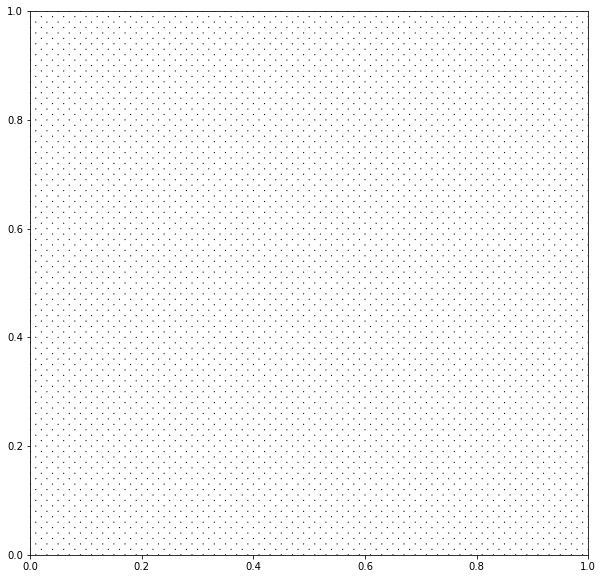

In [21]:
if __name__ == '__main__':
    viewer = Viewer(vars=(velocity),
               xmin=0., xmax=1., ymin=0., ymax=1., colorbar=True,scale=5)

Now solve the problem with sweep instead of solve.

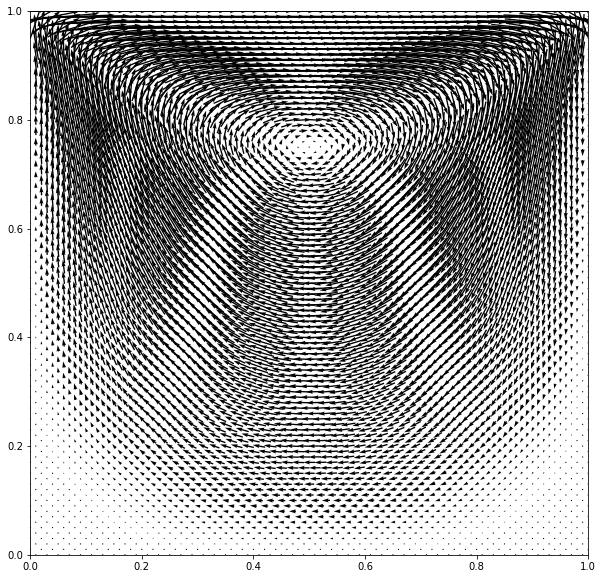

Residuals are less than: 0.01


<Figure size 720x720 with 0 Axes>

In [34]:
from builtins import range
for sweep in range(sweeps):
#while min(xres,yres)>0.01:
    
     ## solve the Stokes equations to get starred values
     xVelocityEq.cacheMatrix()
     
    #solving for x and y velocities
     
     xres = xVelocityEq.sweep(var=xVelocity,
                              underRelaxation=velocityRelaxation)
  
     xmat = xVelocityEq.matrix

     yres = yVelocityEq.sweep(var=yVelocity,
                              underRelaxation=velocityRelaxation)

        #solving again to adjust the x and y velocity values########################
     xres = xVelocityEq.sweep(var=xVelocity,
                              underRelaxation=velocityRelaxation)
     xmat = xVelocityEq.matrix

     yres = yVelocityEq.sweep(var=yVelocity,
                              underRelaxation=velocityRelaxation)
     ############################################################################
     
    
    ## update the ap coefficient from the matrix diagonal
     ap[:] = -numerix.asarray(xmat.takeDiagonal())

     ## update the face velocities based on starred values with the
     ## Rhie-Chow correction.
     ## cell pressure gradient
     presgrad = pressure.grad
     ## face pressure gradient
     facepresgrad = _FaceGradVariable(pressure)

     velocity[0] = xVelocity.arithmeticFaceValue \
         + contrvolume / ap.arithmeticFaceValue * \
            (presgrad[0].arithmeticFaceValue-facepresgrad[0])
     velocity[1] = yVelocity.arithmeticFaceValue \
          + contrvolume / ap.arithmeticFaceValue * \
            (presgrad[1].arithmeticFaceValue-facepresgrad[1])
     velocity[..., mesh.exteriorFaces.value] = 0.
     velocity[0, mesh.facesTop.value] = U

     ## solve the pressure correction equation
     pressureCorrectionEq.cacheRHSvector()
     ## left bottom point must remain at pressure 0, so no correction
     pres = pressureCorrectionEq.sweep(var=pressureCorrection)
     rhs = pressureCorrectionEq.RHSvector

     ## update the pressure using the corrected value
     pressure.setValue(pressure + pressureRelaxation * pressureCorrection )
     ## update the velocity using the corrected pressure
     xVelocity.setValue(xVelocity - pressureCorrection.grad[0] / \
                                                ap * mesh.cellVolumes)
     yVelocity.setValue(yVelocity - pressureCorrection.grad[1] / \
                                                ap * mesh.cellVolumes)
     
    ###Incorporating shear_strain_calculation
     velocity_variable.setValue([xVelocity,yVelocity])
     shear_strain.setValue(velocity_variable.grad)
     du,dv=shear_strain[0]
     dw,dy=shear_strain[1]
     grad_transpose.setValue([[du,dw],[dv,dy]])
     shear_strain.setValue(1./2.*(velocity_variable.grad+grad_transpose))
     shear_cellvalue.setValue((shear_strain[0].mag**2.+shear_strain[1].mag**2.)**0.5)
     SS=shear_cellvalue.value
     xTerm1.setValue([[viscosity*SS**(m-1.),SS*0.],[SS*0.,viscosity*SS**(m-1.)*0.5]])
     xTerm2.setValue([[SS*0.,SS*0.],[viscosity*SS**(m-1.)*0.5,SS*0.]])
     yTerm1.setValue([[SS*0.,viscosity*SS**(m-1)*0.5],[SS*0.,SS*0.]])
     yTerm2.setValue([[viscosity*SS**(m-1)*0.5,SS*0.],[SS*0.,viscosity*SS**(m-1.)]])
             
     if __name__ == '__main__':
         if sweep%50 == 0:
             print('sweep:', sweep, ', x residual:', xres, \
                                  ', y residual', yres, \
                                  ', p residual:', pres, \
                                  ', continuity:', max(abs(rhs)))
             plt.figure(num=1,figsize=(10,10))
      
            
     
             viewer.plot()
     #Criteria to stop
     if (max(xres,yres)<eps):
        print("Residuals are less than: 0.01")
        break        
     else:
        continue

In [33]:
print(max(xres,yres))

0.013359653520144097


Recording the values. First from Cell Centers

In [37]:
np.savetxt('mUV15U1resmax009.csv', [xVelocity.value,yVelocity.value], delimiter=',')
np.savetxt('m15U1resmax009.csv', velocity.value, delimiter=',')

In [36]:
import numpy as np

In [ ]:
#np.savetxt('m15U1resmax009.csv', data, delimiter=',')

In [46]:
#m15_data = np.genfromtxt('m15U1resmax03.csv', delimiter=',')
m10_data = np.genfromtxt('Dadosgravados\m10U1resmax009.csv', delimiter=',')
m05_data = np.genfromtxt('Dadosgravados\m05U1resmax009.csv', delimiter=',')

In [39]:
m15UV_data = np.genfromtxt('mUV15U1resmax009.csv', delimiter=',')

Creating visualization

In [40]:
import plotly.figure_factory as ff

In [41]:
import matplotlib.pyplot as plt

In [42]:
xt,yt=np.meshgrid(X[0:100:2], Y[0:100:2])

In [43]:
u,v=np.meshgrid(X[0:100:2], Y[0:100:2])

In [47]:
i=0
j=0
while (i<=49):
    j=0
    
    while (j<=49):
        u[i,j]=m15UV_data[0][j+i*50]
        v[i,j]=m15UV_data[1][j+i*50]
        j+=1
    i+=1

In [48]:
u10,v10=np.meshgrid(X[0:100:2], Y[0:100:2])
u05,v05=np.meshgrid(X[0:100:2], Y[0:100:2])

In [49]:
i=0
j=0
while (i<=49):
    j=0
    
    while (j<=49):
        u10[i,j]=m10_data[0][j+i*50]
        v10[i,j]=m10_data[1][j+i*50]
        j+=1
    i+=1

In [50]:
i=0
j=0
while (i<=49):
    j=0
    
    while (j<=49):
        u05[i,j]=m05_data[0][j+i*50]
        v05[i,j]=m05_data[1][j+i*50]
        j+=1
    i+=1

In [51]:
Nplot = 50
x_start, x_end = 0., 1.0
y_start, y_end = 0., 1.0
x = np.linspace(x_start, x_end, Nplot)
y = np.linspace(y_start, y_end, Nplot)

In [52]:
magnitude=(u**2.+v**2.)**0.5
magnitude1=(u10**2.+v10**2.)**0.5
magnitude2=(u05**2.+v05**2.)**0.5

Plotting streamlines

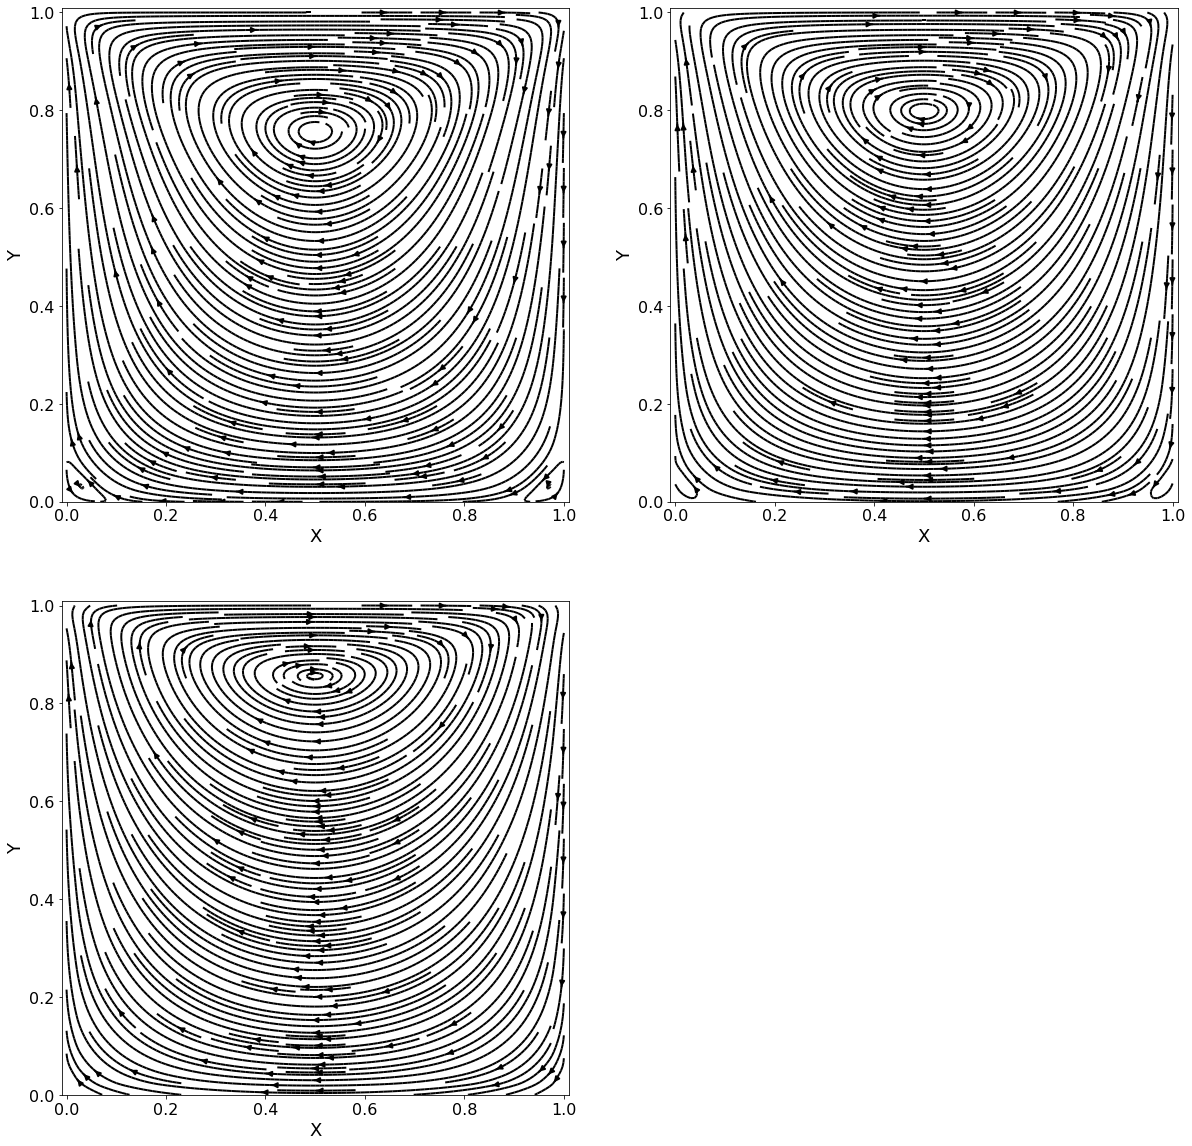

<Figure size 1440x1440 with 0 Axes>

In [53]:
plt.rcParams['figure.figsize']=(20,20)

plt.subplot(2,2,1)
plt.xlim(-0.01,1.01)
plt.ylim(0.,1.01)
plt.xlabel('X', fontsize=18)
plt.ylabel('Y', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.streamplot(x,y,u,v,density=[2,3.6],linewidth=2,color='k')#linewidth=4*(magnitude)**0.5,cmap='gist_heat',color=magnitude)
plt.subplot(2,2,2)
plt.xlim(-0.01,1.01)
plt.ylim(0.0,1.01)
plt.xlabel('X', fontsize=18)
plt.ylabel('Y', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.streamplot(x,y,u10,v10,density=[2,3.6],linewidth=2,color='k')#cmap='gist_heat',color=magnitude1)
plt.subplot(2,2,3)
plt.xlim(-0.01,1.01)
plt.ylim(0.0,1.01)
plt.xlabel('X', fontsize=18)
plt.ylabel('Y', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.streamplot(x,y,u05,v05,density=[2,3.6],linewidth=2,color='k')#cmap='gist_heat',color=magnitude2)
plt.figure().savefig('Stokes3M.eps',format='eps')

In [ ]:
plt.savefig('Stokes3M.eps',format='eps')

In [ ]:
plt.figure().savefig('Stokes3M.eps',format='eps')